In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [14]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags from tweets;'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)

In [15]:
import pickle
!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
r.keys()

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


[b'tweets_tfd_svd_pipe',
 b'hashtags_countvec_fit_transform',
 b'tweet_tfidf_fit',
 b'tweet_tfidf_fit_transform',
 b'hashtags_countvec_fit_temp',
 b'temp_hash_count_12hr',
 b'tweet_SVD_fit',
 b'hashtags_countvec_fit',
 b'hashtags_tfidf_fit_transform',
 b'hashtag_tfidf']

In [16]:
tfd_svd_pipe = pickle.loads(r.get('tweets_tfd_svd_pipe'))

In [17]:
TFIDF_fit =  tfd_svd_pipe.steps[0][1]
SVD_fit = tfd_svd_pipe.steps[1][1]

In [79]:
tdf_word_index = TFIDF_fit.get_feature_names()

In [8]:
def event_tweet_count(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    return len(event_tweet)

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def svd_variance(svd_model, col_index):
    
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(SVD_fit.components_)+1)]
    components = pd.DataFrame(np.round(SVD_fit.components_, 4), columns=col_index)
    ratios = SVD_fit.explained_variance_ratio_.reshape(len(SVD_fit.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    fig, ax = plt.subplots(figsize = (24,10))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar',legend='False');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    ax.legend_.remove()


    # Display the explained variance ratios
    for i, ev in enumerate(SVD_fit.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

In [102]:
def tweets_event_kmean(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True)
    A_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in event_tweet['cleaned_tweet']])
    
    non_event_tweet = df[~df['cleaned_tweet'].str.contains(('event'))]
    non_event_tweet.reset_index(inplace = True)
    non_event_index = list(range(non_event_tweet.shape[0]))
    random.shuffle(non_event_index)
    n = len(event_tweet)
    B_index = []
    for i in range(n):
        B_index.append(non_event_index.pop())
    B = non_event_tweet.iloc[B_index,:]
    B_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B['cleaned_tweet']])
    
    component_1 = np.argsort(SVD_fit.explained_variance_ratio_)[::-1][0]
    component_2 = np.argsort(SVD_fit.explained_variance_ratio_)[::-1][1]
    e = ['event', 'non-event']
    for vec, t in zip([A_vec,B_vec],e):
        ks = []
        sils = []
        plt.figure(figsize=(16,4))
        for i,k  in enumerate(range(2,5)):
            km = KMeans(n_clusters=k)
            km.fit(vec)
            plt.subplot(131+i)
            plt.scatter(vec.T[component_1], vec.T[component_2], c=km.labels_, cmap='magma')
            plt.title('{}\nK:{}   sil:{}'.format(t,k, round(silhouette_score(vec, km.labels_),4)))
            plt.colorbar()
            ks.append(k)
            sils.append(silhouette_score(vec, km.labels_))
    
    return km.labels_

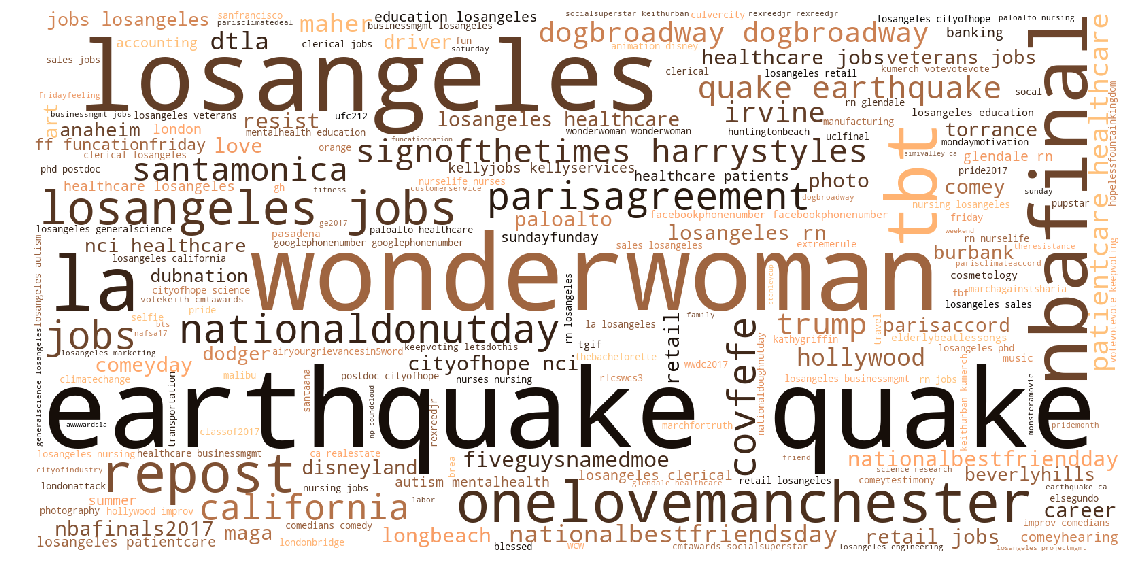

In [98]:
words = df['hashtags'][(df['hashtags'].isnull() == False) & (df['hashtags'] != 'None')]
stopwords = set(STOPWORDS)
stopwords.add("job")
stopwords.add("careerarc")
stopwords.add("hiring")
wc = WordCloud(width=1600, height=800, background_color='white', \
               relative_scaling=1, stopwords=stopwords, colormap='copper').generate(' '.join(i for i in words))


plt.figure(figsize=(20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

Event Tweets (wonderwoman):  1505


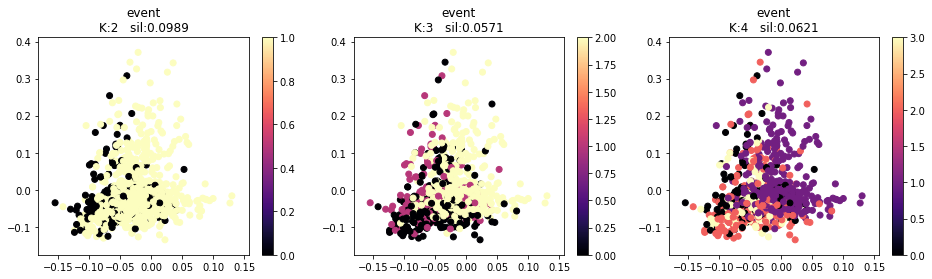

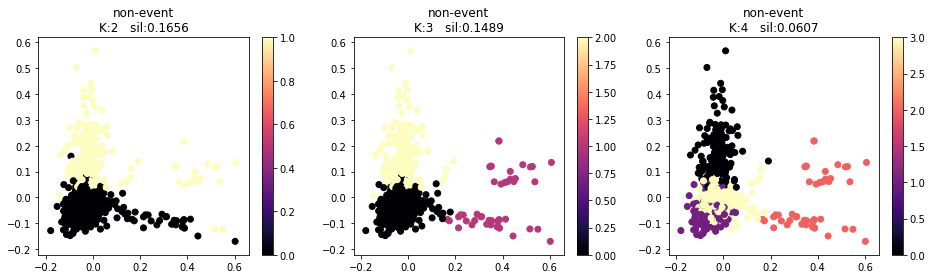

In [99]:
print('Event Tweets (wonderwoman): ', event_tweet_count('wonderwoman'))
tweets_event_kmean('wonderwoman')

Event Tweets (earthquake):  1222


array([1, 0, 2, ..., 1, 0, 1], dtype=int32)

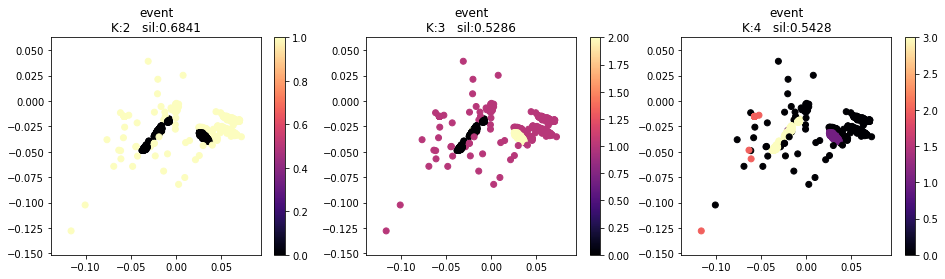

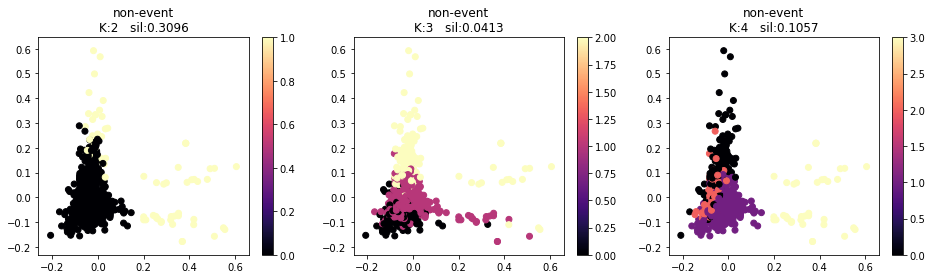

In [103]:
print('Event Tweets (earthquake): ', event_tweet_count('earthquake'))
tweets_event_kmean('earthquake')

Event Tweets (onelovemanchester):  701


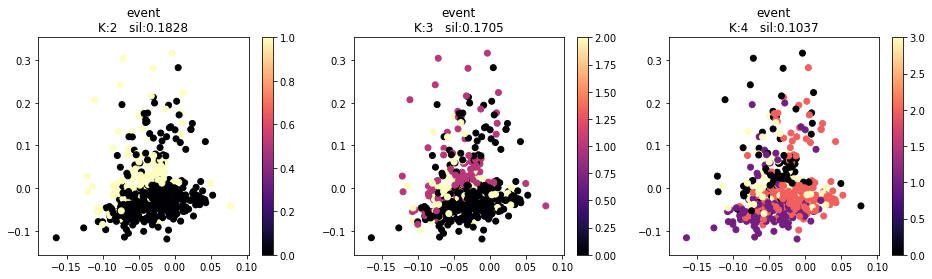

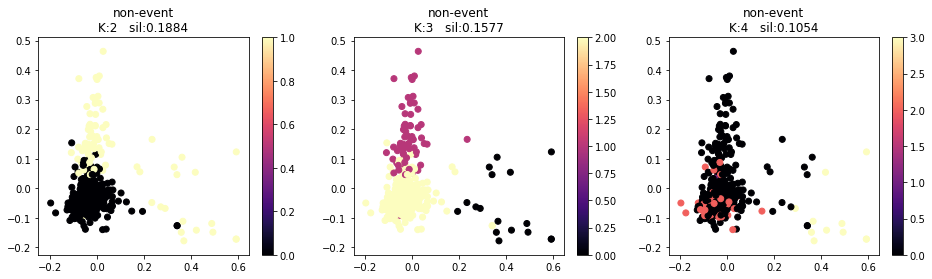

In [101]:
print('Event Tweets (onelovemanchester): ', event_tweet_count('onelovemanchester'))
tweets_event_kmean('onelovemanchester')

In [ ]:
svd_variance(SVD_fit,tdf_word_index)

In [ ]:
features = tfd.vocabulary_

In [90]:
np.argsort(SVD_fit.explained_variance_ratio_)[::-1][0]

1

In [85]:
SVD_fit.explained_variance_ratio_

array([ 0.00493243,  0.00824634,  0.00620914,  0.00511295,  0.00471954,
        0.00427937,  0.0039975 ,  0.00395309,  0.00359295,  0.00353129,
        0.0033569 ,  0.00324694,  0.00315402,  0.00306293,  0.00298332,
        0.00290607,  0.00283645,  0.00274264,  0.00272527,  0.00270692,
        0.00264602,  0.00260118,  0.00259162,  0.00253521,  0.00248824,
        0.0024421 ,  0.00241064,  0.00238916,  0.00228428,  0.0022414 ,
        0.00217367,  0.00210099,  0.00204503,  0.00203761,  0.00200217,
        0.00199891,  0.00197245,  0.00196668,  0.00194968,  0.00188665,
        0.00187729,  0.00183828,  0.00180151,  0.00177343,  0.00177105,
        0.00174211,  0.0017195 ,  0.00168563,  0.00166559,  0.00165073])